# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [5]:

%load_ext autoreload
%autoreload 2


import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier




## Setting the device

In [6]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [7]:
if device != 'mps':
    !nvidia-smi


Sun Feb 25 18:50:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8               3W /  80W |     53MiB /  8188MiB |     29%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [8]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [9]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df
also I was the point person on my company's transition from the KL-5 to GR-6 system. [SEP] You must've had your hands full. [SEP] That I did. That I did. [SEP] So let's talk a little bit about you...[sep] pad [sep]

,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting Word Cloud 

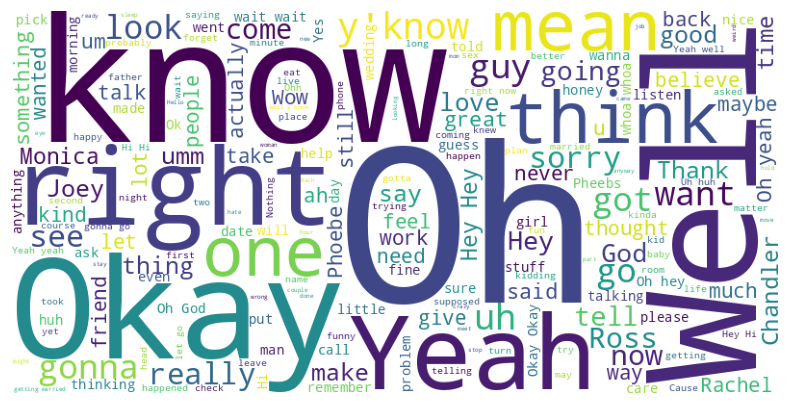

In [10]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [11]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [12]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Removing NaN Values

In [13]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [14]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [15]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 

In the following cell, individual utterances constituting a dialogue are concatenated to form a single string while preserving separation through the addition of the token '[SEP]'.

In [16]:
df['processed_utterances'] = df['utterances'].apply(concat_with_sep)
df['processed_utterances']


episode
utterance_0       also I was the point person on my company's tr...
utterance_1       also I was the point person on my company's tr...
utterance_2       also I was the point person on my company's tr...
utterance_3       also I was the point person on my company's tr...
utterance_4       But then who? The waitress I went out with las...
                                        ...                        
utterance_3995    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3996    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3997    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3998    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3999    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
Name: processed_utterances, Length: 4000, dtype: object

### Splitting the dataset 

In [17]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_715,"[Phoebe, Rachel, Phoebe]","[neutral, neutral, joy]","[Good!, Pick one., Left! Thank you.]","[0.0, 1.0, 0.0]",Good! [SEP] Pick one. [SEP] Left! Thank you.
utterance_1780,"[Chandler, Dana, Chandler, Dana, Dana, Dana, D...","[joy, neutral, neutral, neutral, anger, surpri...","[Oh that's great, my friend Joey's in the movi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","Oh that's great, my friend Joey's in the movie..."
utterance_1555,"[Joey, Man, Joey, Joey, Man, Joey, Man, Joey, ...","[neutral, surprise, neutral, neutral, surprise...",[Hi! I'm Dr. Drake Remoray and I have a few ro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hi! I'm Dr. Drake Remoray and I have a few rou...
utterance_1447,"[Phoebe, Ross, Phoebe, Ross, Ross, Phoebe]","[anger, joy, sadness, sadness, neutral, neutral]","[Well, that's not something a girl wants to he...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","Well, that's not something a girl wants to hea..."
utterance_768,"[Danny, Joey, Chandler, Joey, Chandler, Krista...","[disgust, neutral, surprise, neutral, disgust,...",[so we finally get to the top of the mountain ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",so we finally get to the top of the mountain a...


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_627,"[Joey, Monica, Rachel, Monica, Rachel, Rachel,...","[neutral, joy, joy, neutral, surprise, anger, ...","[We did?, You owe me 20 bucks., Thank you. Tha...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",We did? [SEP] You owe me 20 bucks. [SEP] Thank...
utterance_2061,"[Joshua, Rachel, Joshua, Rachel]","[neutral, fear, neutral, joy]",[All those things I said about not being ready...,"[0.0, 0.0, 1.0, 0.0]",All those things I said about not being ready ...
utterance_2485,"[Chandler, Phoebe, Chandler, Chandler]","[neutral, neutral, joy, neutral]","[OK, that's enough of the view. Check this out...","[0.0, 0.0, 0.0, 1.0]","OK, that's enough of the view. Check this out,..."
utterance_3642,"[Chandler, Monica, Ross, Ross, All, Ross, Moni...","[surprise, sadness, anger, disgust, sadness, a...","[Oh my God!, We heard about your pants, I'm so...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Oh my God! [SEP] We heard about your pants, I'..."
utterance_960,"[Chandler, Monica, Chandler]","[joy, neutral, surprise]","[Oh-hey-hey-hey! There you are!, Umm, listen t...","[0.0, 1.0, 0.0]","Oh-hey-hey-hey! There you are! [SEP] Umm, list..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_1606,"[Mrs. Geller, Ross, Rachel, Mrs. Geller, Mr. G...","[neutral, joy, joy, surprise, surprise, neutra...","[Hi, Hi! Hey mom., This is such a great party...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",Hi [SEP] Hi! Hey mom. [SEP] This is such a gr...
utterance_312,"[Monica, Phoebe, Rachel, Phoebe, Rachel]","[fear, anger, anger, anger, neutral]","[No-no, Rachel, don't get it! He can't see us!...","[0.0, 0.0, 0.0, 0.0, 1.0]","No-no, Rachel, don't get it! He can't see us! ..."
utterance_801,"[Ross, Ross, Ross, Monica, Joey, Joey, Joey]","[neutral, neutral, neutral, sadness, neutral, ...","[Okay, Mon, back me up here., Where you work t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","Okay, Mon, back me up here. [SEP] Where you wo..."
utterance_3306,"[Joey, Ross, Chandler, Chandler, Chandler, Ros...","[surprise, surprise, anger, anger, neutral, fe...","[Mark's a genius!, Why?! How?! How is he a gen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Mark's a genius! [SEP] Why?! How?! How is he a...
utterance_3670,"[Monica, Allesandro, Monica]","[anger, neutral, neutral]",[The waiter carried the breadsticks in his pan...,"[0.0, 0.0, 0.0]",The waiter carried the breadsticks in his pant...


### Visualizing the distribution of the emotions over the datasets

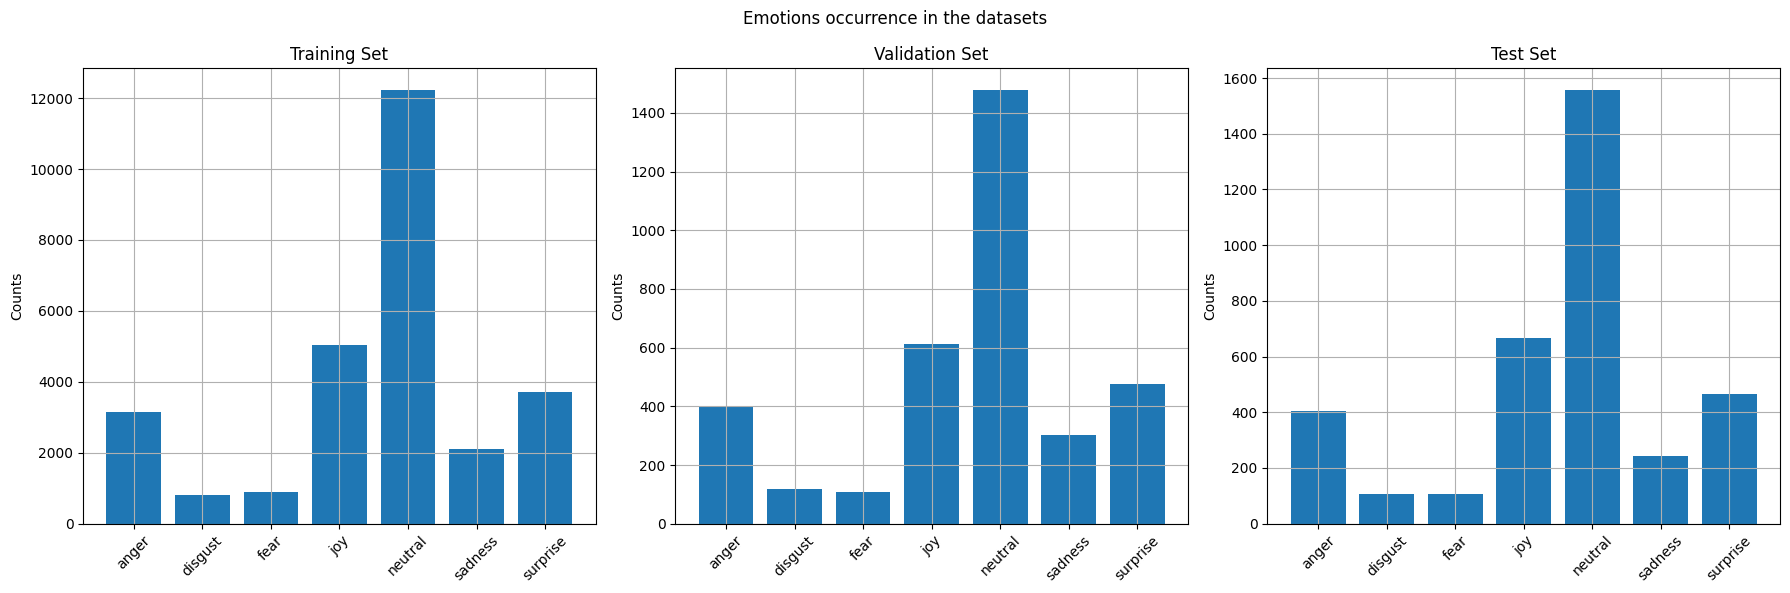

In [18]:
plot_emotion_distribution(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [19]:
from IPython.display import display
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
trigger_weights = create_classes_weights(df['triggers'].sum())

print('Emotion weights')
display(pd.DataFrame({'Emotion': EMOTIONS, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': [0, 1], 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426


Trigger weights


,Trigger,Weight
0,0,0.594761
1,1,3.138206


## Random Classifier

In [20]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Mrs. Geller,neutral,Hi,0.0,disgust,0
1,Ross,joy,Hi! Hey mom.,0.0,anger,1
2,Rachel,joy,This is such a great party! 35 years. Very imp...,0.0,joy,0
3,Mrs. Geller,surprise,Jack?,0.0,fear,0
4,Mr. Geller,surprise,Why would you serve food on such a sharp stick?,0.0,surprise,0
5,Ross,neutral,"That's a good question, dad. That's a good que...",0.0,neutral,1
6,an,joy,Congratulations you two!,0.0,surprise,1
7,Rachel,joy,Thank you we're so excited,0.0,disgust,0
8,an,joy,"And also, congratulations on your wedding.",1.0,neutral,0
9,Ross,surprise,WhaWhat?,0.0,sadness,1


## Majority Classifier

In [21]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Mrs. Geller,neutral,Hi,0.0,neutral,0.0
1,Ross,joy,Hi! Hey mom.,0.0,neutral,0.0
2,Rachel,joy,This is such a great party! 35 years. Very imp...,0.0,neutral,0.0
3,Mrs. Geller,surprise,Jack?,0.0,neutral,0.0
4,Mr. Geller,surprise,Why would you serve food on such a sharp stick?,0.0,neutral,0.0
5,Ross,neutral,"That's a good question, dad. That's a good que...",0.0,neutral,0.0
6,an,joy,Congratulations you two!,0.0,neutral,0.0
7,Rachel,joy,Thank you we're so excited,0.0,neutral,0.0
8,an,joy,"And also, congratulations on your wedding.",1.0,neutral,0.0
9,Ross,surprise,WhaWhat?,0.0,neutral,0.0


## Bert Models

In [22]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [38]:
from typing import Dict
from DrTorch.utilities import DataLoaderFromPipelineStrategy
 
def tokenize_data(data):
    tokenizer = BertTokenizer.from_pretrained("local-bert")

    output =  tokenizer.batch_encode_plus(data,
                                          return_tensors="pt",
                                          padding=True, 
                                          return_token_type_ids=True)  

    output['t_sep_index'] = torch.isin(output['input_ids'], torch.tensor([0, 101, 102]))
    
    return output

def preprocess_labels(labels):
    emotions, triggers = labels['emotions'].sum(), labels['triggers'].sum()
    encoded_emotions = torch.tensor(pd.get_dummies(emotions).astype(float).values)
    encoded_triggers = torch.tensor(triggers)
    output = {'emotions': encoded_emotions,
              'triggers': encoded_triggers}    
    
    return output           #{emotions:[N,N_Em],     triggers[N,]       # per invertire one hot enc pd.get_dummies(emotions).idxmax(axis=1)
                            #Crosentropy(softmax),   BCE (sigmoid)
                            
 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df["processed_utterances"].copy(), 
                                      train_df[["emotions", "triggers"]].copy(), 
                                      shuffle=True,
                                      data_preprocess_f=tokenize_data, 
                                      labels_preprocess_f=preprocess_labels,
                                      batch_size=2,
                                      device=device)


for data, label in dataloader:
   print('DATA') 
   print(data['t_sep_index'][0])
   print(data['input_ids'][0])

   break
    



DATA
tensor([ True, False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True, Fa

In [42]:
from models.bertFreezed import * 
bertest= BertFreezed(bert_model=bert_model)

for data, label in dataloader:
    bertest(data)
    break



torch.Size([2, 411, 768])
2
17
torch.Size([18, 768])
torch.Size([5, 768])
torch.Size([10, 768])


TypeError: linear(): argument 'input' (position 1) must be Tensor, not list